>># **PROJET : Classifiez automatiquement des biens de consommation**

>>>Source du jeu de données : https://rapidapi.com/edamam/api/edamam-food-and-grocery-database

>>>>>># **TRAITEE PROJET : notebook 4/4**  

# **Charger les données**

> ## Fichier CSV

In [1]:
# import des librairies nécessaires
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
mon_df = pd.read_csv('final_df.csv')

In [3]:
mon_df.head()

,_category_,_category_label_,description,_clean_text_,image
0,Home Furnishing,4,Key Features of Elegance Polyester Multicolor ...,"['key', 'featur', 'eleg', 'polyest', 'multicol...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,0,Specifications of Sathiyas Cotton Bath Towel (...,"['specif', 'cotton', 'bath', 'towel', 'bath', ...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,0,Key Features of Eurospa Cotton Terry Face Towe...,"['key', 'featur', 'cotton', 'terri', 'face', '...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,4,Key Features of SANTOSH ROYAL FASHION Cotton P...,"['key', 'featur', 'royal', 'fashion', 'cotton'...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,4,Key Features of Jaipur Print Cotton Floral Kin...,"['key', 'featur', 'print', 'cotton', 'floral',...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [4]:
df_image = mon_df[['image', '_category_']]

In [5]:
df_image.columns

Index(['image', '_category_'], dtype='object')

> ## Photos

In [6]:
# Import des bibliothèques nécessaires pour la manipulation d'images
import os
import cv2  # OpenCV pour le traitement des images

In [7]:
# Faire monter le Google Drive dans Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Afficher les images**

In [8]:
# Chemin d'accès au dossier contenant les photos dans votre Google Drive
folder_path = '/content/drive/MyDrive/Images/'

In [9]:
# Liste pour stocker les images chargées
images_list = []

# Parcourez le dossier et chargez les images
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Vous pouvez ajouter d'autres extensions d'images si nécessaire
        image_path = os.path.join(folder_path, filename)
        img = cv2.imread(image_path)
        images_list.append(img)

In [10]:
# Affichez le nombre d'images chargées
print("Nombre d'images chargées :", len(images_list))

Nombre d'images chargées : 1050


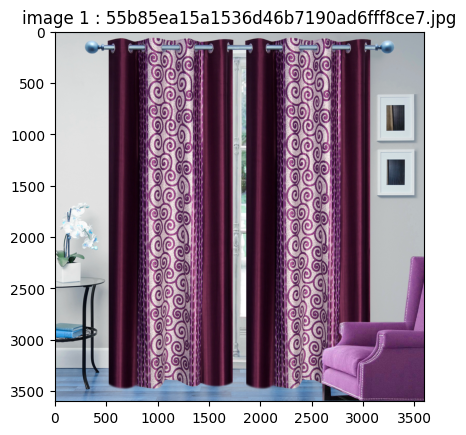

In [11]:
# Chargement de l'image
image_1 = folder_path + df_image.image[0]
image = cv2.imread(image_1)
plt.title('image 1 : 55b85ea15a1536d46b7190ad6fff8ce7.jpg')
plt.imshow(image)

# **Transfert learning VGG16 (non supervisé)**



In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

> Fonctions communes

In [13]:
# Fonction pour traiter l'image
def preprocess_image(image):
    # fonction de traitement d'image ici
    img_noNoise = cv2.boxFilter(image, -1, (25, 25))
    img_NB = cv2.cvtColor(img_noNoise, cv2.COLOR_BGR2GRAY)
    img_contrast = cv2.equalizeHist(img_NB)
    dsize = (224, 224)
    img_resized = cv2.resize(img_contrast, dsize)
    sift = cv2.xfeatures2d.SIFT_create(200)
    kp, des = sift.detectAndCompute(img_resized, None)
    img_feat_sift = cv2.drawKeypoints(img_resized, kp, img_NB)
    return img_feat_sift

In [14]:
# Fonction pour créer le modèle VGG16
def create_vgg16_model(input_shape, num_classes):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    prediction = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=prediction)

    return model

In [15]:
# Fonction pour compiler le modèle
def compile_model(model):
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

In [16]:
# Fonction pour créer les générateurs de données
def create_data_generators(X_train, X_test, y_train, y_test, folder_path, target_size, batch_size):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

    train_generator = train_datagen.flow(
        x=X_train,
        y=y_train,
        #directory=folder_path,
        #target_size=target_size,
        batch_size=batch_size,
        #class_mode='categorical'
        shuffle=False
    )

    test_generator = test_datagen.flow(
        x=X_test,
        y=y_test,
        #directory=folder_path,
        #target_size=target_size,
        batch_size=batch_size,
        #class_mode='categorical'
        shuffle=False
    )

    return train_generator, test_generator

In [17]:
# Fonction pour ploter la courbe de perte et la courbe d'exactitude

def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

# Fermer la figure pour libérer la mémoire
plt.close()


In [18]:
# Liste pour stocker les images chargées
images_list = []
labels_list = []

# Parcourir le DataFrame et chargez les images avec leurs étiquettes correspondantes
for index, row in df_image.iterrows():
    filename = row['image']
    label = row['_category_']

    image_path = os.path.join(folder_path, filename)
    img = cv2.imread(image_path)

    if img is not None:
        preprocessed_img = preprocess_image(img)
        images_list.append(preprocessed_img)
        labels_list.append(label)

# Convertir les listes en tableaux NumPy pour le traitement ultérieur
X = np.array(images_list)
y = np.array(labels_list)

In [19]:
# Diviser le DataFrame en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape

(840, 224, 224, 3)

In [21]:
X_test.shape

(210, 224, 224, 3)

In [22]:
num_classes = len(np.unique(y_train))
num_classes

7

In [23]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Maintenant, on peut utiliser to_categorical
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

In [24]:
# Définir la taille cible des images
target_size = (224, 224)

In [25]:
# Créer le modèle VGG16
model = create_vgg16_model(input_shape=target_size + (3,), num_classes=df_image['_category_'].nunique())

58889256/58889256 [==============================] - 0s 0us/step


In [26]:
# Afficher le résumé du modèle
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
# Compiler le modèle
compile_model(model)

In [30]:
# Définir la taille des lots
batch_size = 32

In [31]:
# Créer les générateurs de données
train_generator, test_generator = create_data_generators(X_train, X_test, y_train_one_hot , y_test_one_hot , folder_path, target_size, batch_size)

#train_generator, test_generator = create_data_generators(train_df, test_df, folder_path, target_size, batch_size)

In [32]:
print('la longueur de train_generator : ', len(train_generator))
print('la longueur de test_generator : ', len(test_generator))

la longueur de train_generator :  27
la longueur de test_generator :  7


In [33]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Définir les callbacks
model_checkpoint = ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

callbacks_list = [model_checkpoint, early_stopping]

In [34]:
# Entraîner sur les données d'entraînement (train_generator)
history = model.fit(train_generator,
                    epochs=10,
                    batch_size=batch_size,
                    callbacks=callbacks_list,
                    validation_data=test_generator,
                    verbose=1)


Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 6.1397 - accuracy: 0.1774 
Epoch 1: val_loss improved from inf to 5.29507, saving model to model_checkpoint.h5
27/27 [==============================] - 699s 26s/step - loss: 6.1397 - accuracy: 0.1774 - val_loss: 5.2951 - val_accuracy: 0.2762
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 3.5650 - accuracy: 0.3143 
Epoch 2: val_loss improved from 5.29507 to 3.61110, saving model to model_checkpoint.h5
27/27 [==============================] - 701s 26s/step - loss: 3.5650 - accuracy: 0.3143 - val_loss: 3.6111 - val_accuracy: 0.4143
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 2.7902 - accuracy: 0.4190 
Epoch 3: val_loss improved from 3.61110 to 2.97176, saving model to model_checkpoint.h5
27/27 [==============================] - 702s 26s/step - loss: 2.7902 - accuracy: 0.4190 - val_loss: 2.9718 - val_accuracy: 0.4714
Epoch 4/10
27/27 [==============================] - ETA: 0s - 

In [35]:
# Afficher les valeurs training history
print("Training history:")
display("Loss evolution:", history.history['loss'])
print()
display("Accuracy evolution:", history.history['accuracy'])
print()
display("Validation loss evolution:", history.history['val_loss'])
print()
display("Validation accuracy evolution:", history.history['val_accuracy'])

Training history:


'Loss evolution:'

[6.13972282409668,
 3.5650250911712646,
 2.7901666164398193,
 2.390076160430908,
 2.0333027839660645,
 1.7730764150619507,
 1.6490894556045532,
 1.5832792520523071,
 1.4222592115402222,
 1.3996397256851196]

'Accuracy evolution:'

[0.17738094925880432,
 0.3142857253551483,
 0.41904762387275696,
 0.488095223903656,
 0.5273809432983398,
 0.5678571462631226,
 0.586904764175415,
 0.6059523820877075,
 0.6023809313774109,
 0.6166666746139526]

'Validation loss evolution:'

[5.295068264007568,
 3.611100912094116,
 2.971755027770996,
 2.7252371311187744,
 2.459289073944092,
 2.444631814956665,
 2.526308536529541,
 2.2324347496032715,
 2.358947515487671,
 1.9975301027297974]

'Validation accuracy evolution:'

[0.27619048953056335,
 0.41428571939468384,
 0.4714285731315613,
 0.5476190447807312,
 0.538095235824585,
 0.5571428537368774,
 0.5476190447807312,
 0.5761904716491699,
 0.5523809790611267,
 0.6190476417541504]

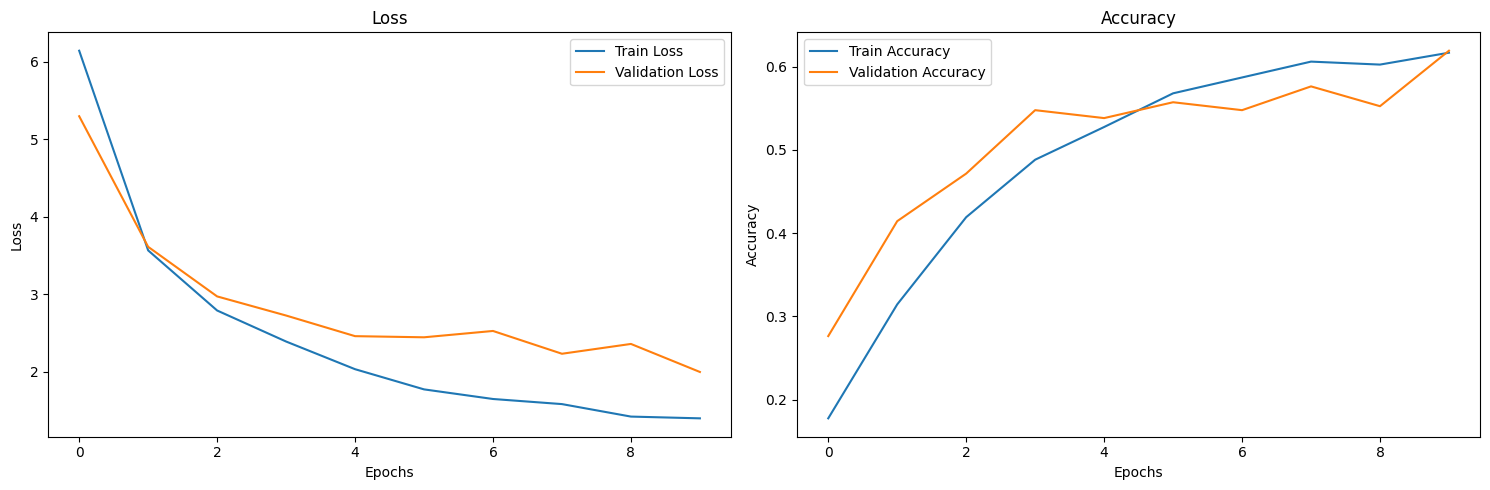

In [36]:
# Tracer et enregistrer le graphique de l'historique
plot_training_history(history)
#plt.savefig('training_history.png')

> Extraire les vecteurs de caractéristiques aplatis du modèle VGG16

In [37]:
# Trouver l'indice de la couche de mise en commun de la moyenne globale
gap_layer_index = None
for index, layer in enumerate(model.layers):
    if isinstance(layer, GlobalAveragePooling2D):
        gap_layer_index = index
        break

if gap_layer_index is None:
    raise ValueError("Global Average Pooling layer not found in the model.")

# Obtenir la sortie de la couche Global Average Pooling
flatten_model = tf.keras.Model(inputs=model.input, outputs=model.layers[gap_layer_index].output)

X_flatten_train = flatten_model.predict(X_train)
X_flatten_test = flatten_model.predict(X_test)


7/7 [==============================] - 136s 19s/step


In [38]:
from sklearn.cluster import KMeans

# Liste des catégories uniques
true_labels = df_image['_category_'].unique()

# Appliquer le K-means clustering
num_clusters = len(true_labels)
print(num_clusters)
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
y_pred_train = kmeans.fit_predict(X_flatten_train)

7


Maintenant que j'ai les prédictions de cluster y_pred pour les données d'entraînement, je peux associer ces prédictions à aux données de test pour prédire les images.


> ## Prédiction d'une image _ exemple

In [39]:
# Mappage des numéros de cluster aux noms de catégories
cluster_to_category = {}
for cluster_num, category in enumerate(true_labels):
    cluster_to_category[cluster_num] = category

# Prédictions sur les données de test
y_pred_test = kmeans.predict(X_flatten_test)

# Mapping des numéros de cluster aux noms de catégories prédites
predicted_categories = [cluster_to_category[cluster_num] for cluster_num in y_pred_test]

In [40]:
from sklearn.preprocessing import LabelEncoder

# Encoder les catégories prédites en valeurs numériques
label_encoder = LabelEncoder()
encoded_categories = label_encoder.fit_transform(predicted_categories)

In [41]:
# Supposons que je sélectionne un numéro de cluster au hasard, par exemple :
random_cluster_num = 5

# Trouver les indices des images appartenant au cluster sélectionné
indices_of_selected_cluster = [index for index, cluster_num in enumerate(encoded_categories) if cluster_num == random_cluster_num]

In [42]:
import random
# Sélectionner un index d'image aléatoire du cluster choisi
random_image_index = random.choice(indices_of_selected_cluster)
random_image_index

156

In [43]:
# Obtenir la catégorie prédite pour le cluster choisi
selected_predicted_category = predicted_categories[random_image_index]
selected_predicted_category

'Kitchen and Dining'

In [44]:
# Trouver toutes les entrées dans le dataframe correspondant à la catégorie prédite
images_with_selected_category = df_image[df_image['_category_'] == selected_predicted_category]
images_with_selected_category

,image,_category_
37,e9420e9483f16db81c64dddf99f34841.jpg,Kitchen and Dining
38,a3dea07b2f7bf48276d32513091be717.jpg,Kitchen and Dining
44,8050d31bffe6827c804b8222338aafb2.jpg,Kitchen and Dining
45,493d1eb6ad7a48a926092bf994cd0bb0.jpg,Kitchen and Dining
46,3388d05e88972ff9f3e1321dc0cfdc28.jpg,Kitchen and Dining
...,...,...
994,fc8ff72b68b0f3736a9aff8f03aa712f.jpg,Kitchen and Dining
998,78fcb634d9838127464d827234ab05ad.jpg,Kitchen and Dining
1000,4cc971d2c9c0f1056bc124031ed52c1e.jpg,Kitchen and Dining
1003,0c70a580d96e50966130e2885d8c3505.jpg,Kitchen and Dining


In [45]:
# Sélectionner une image aléatoire parmi celles qui ont la catégorie prédite
random_selected_image_entry = images_with_selected_category.sample()
random_selected_image_entry

,image,_category_
170,9077acd25761ea067ac6d9369d8fdf16.jpg,Kitchen and Dining


In [46]:
# Obtenir le chemin de l'image à partir de l'entrée sélectionnée
selected_image_path = folder_path + random_selected_image_entry['image'].values[0]
selected_image_path

'/content/drive/MyDrive/Images/9077acd25761ea067ac6d9369d8fdf16.jpg'

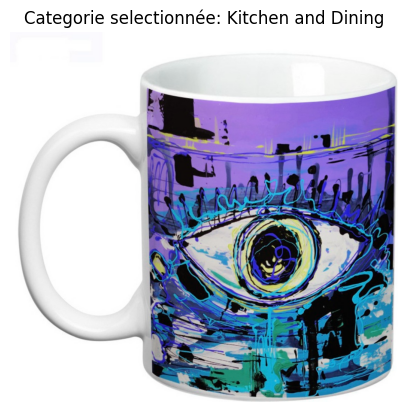

In [47]:
# Charger l'image
selected_image = cv2.imread(selected_image_path)

# Afficher l'image
plt.imshow(selected_image)
plt.title(f"Categorie selectionnée: {selected_predicted_category}")
plt.axis('off')
plt.show()

> ## t-SNE pour reduire les dimensions

In [48]:
from sklearn.manifold import TSNE

# Appliquer la t-SNE pour reduire les dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_flatten_train)

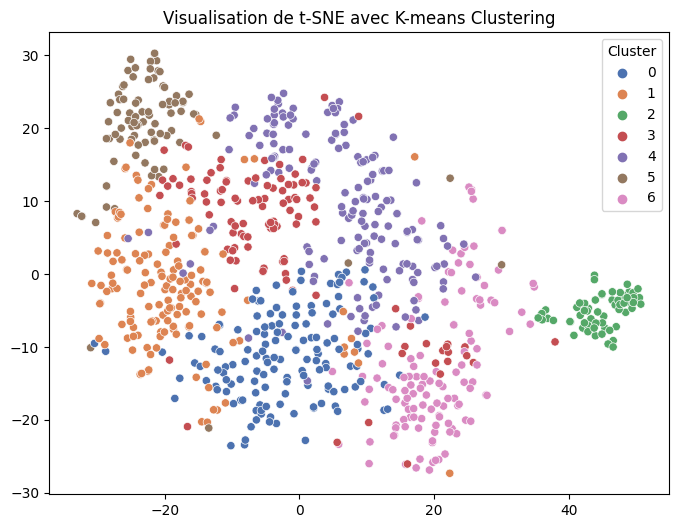

In [49]:
# Visualize t-SNE results with clustering using seaborn
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_pred_train, palette="deep")
scatter.set_title('Visualisation de t-SNE avec K-means Clustering')
plt.legend(title="Cluster")
plt.show()